<div style="width:90%;
            margin:10px;
            padding:8px;
            border:2px solid #FF0000;
            border-radius:20px;
            font-weight:bold;
            font-size:2.5em;
            text-align:center;">
The Robot Arm Problem
</div>


<div style="width:90%;
            margin:9px;
            font-size:1em;">
            
*The Robot Arm Problem:* We aim to Minimize the time taken for a robot arm to travel between two points.                
The problem is inspired from the following paper: [Benchmarking Optimization Software with COPS 3.0](https://www.mcs.anl.gov/~more/cops/cops3.pdf).                             
We solve the problem using the [JuMP](https://jump.dev/) and [OptimalControl](https://control-toolbox.org/OptimalControl.jl/stable/) packages in Julia then we compare the results.

1. [JuMP Formulation](#jump)
2. [OptimalControl Formulation](#oc)
3. [Comparison](#comp)

</div>

## 1. Solving with JuMP <a id='jump'></a>

In [3]:
using JuMP , Ipopt
include("../Problems/JuMP/robot_JMP.jl")
nh=100
N = nh
RobotJMP = robot_JMP(;nh)

set_optimizer(RobotJMP,Ipopt.Optimizer)
set_attribute(RobotJMP, "print_level", 5)
set_optimizer_attribute(RobotJMP,"tol",1e-8)
set_optimizer_attribute(RobotJMP,"constr_viol_tol",1e-6)
set_optimizer_attribute(RobotJMP,"max_iter",1000)
set_optimizer_attribute(RobotJMP,"mu_strategy","adaptive")
set_optimizer_attribute(RobotJMP,"linear_solver","mumps")

In [4]:
println("Solving...")
optimize!(RobotJMP)
println()

# Display results
if termination_status(RobotJMP) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(RobotJMP) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(RobotJMP) == MOI.TIME_LIMIT && has_values(RobotJMP)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
println("  objective value = ", objective_value(RobotJMP))
println()


# Retrieves values (including duals - sign convention according to Pontrjagin max principle)
L = 5.0

rho_ = RobotJMP[:rho];
the_ = RobotJMP[:the];
phi_ = RobotJMP[:phi];

rho_dot_ = RobotJMP[:rho_dot];
the_dot_ = RobotJMP[:the_dot];
phi_dot_ = RobotJMP[:phi_dot];

u_rho_ = RobotJMP[:u_rho];
u_the_ = RobotJMP[:u_the];
u_phi_ = RobotJMP[:u_phi];

con_rho = RobotJMP[:con_rho];
con_the = RobotJMP[:con_the];
con_phi = RobotJMP[:con_phi];
con_rho_dot = RobotJMP[:con_rho_dot];
con_the_dot = RobotJMP[:con_the_dot];
con_phi_dot = RobotJMP[:con_phi_dot];

p = [ [ dual(con_rho[2]), dual(con_the[2]), dual(con_phi[2]), dual(con_rho_dot[2]), dual(con_the_dot[2]), dual(con_phi_dot[2]) ] ];
p = -[ p;[[ dual(con_rho[i]), dual(con_the[i]), dual(con_phi[i]), dual(con_rho_dot[i]), dual(con_the_dot[i]), dual(con_phi_dot[i]) ] for i in 2:N+1] ];

tf = value.(RobotJMP[:tf])
t = Vector((0:N)*tf/N);

rho = Vector(value.(rho_)) ;
the = Vector(value.(the_)) ;
phi = Vector(value.(phi_)) ;
phi_dot = Vector(value.(phi_dot_)) ;
the_dot = Vector(value.(the_dot_)) ;
rho_dot = Vector(value.(rho_dot_)) ;

u_phi = Vector(value.(u_phi_)) ;
u_the = Vector(value.(u_the_)) ;
u_rho = Vector(value.(u_rho_)) ;

u = [ [ u_rho[i], u_the[i], u_phi[i] ] for i in 1:N+1 ];
x =  [ [ rho[i],rho_dot[i],the[i],the_dot[i],phi[i],phi_dot[i] ] for i in 1:N+1 ];


Solving...
This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4012
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5100

Total number of variables............................:      910
                     variables with only lower bounds:        1
                variables with lower and upper bounds:      606
                     variables with only upper bounds:        0
Total number of equality constraints.................:      612
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+00 4.23e+00 0.00e+00   0.0 0.00e+00    -  0.00e+0

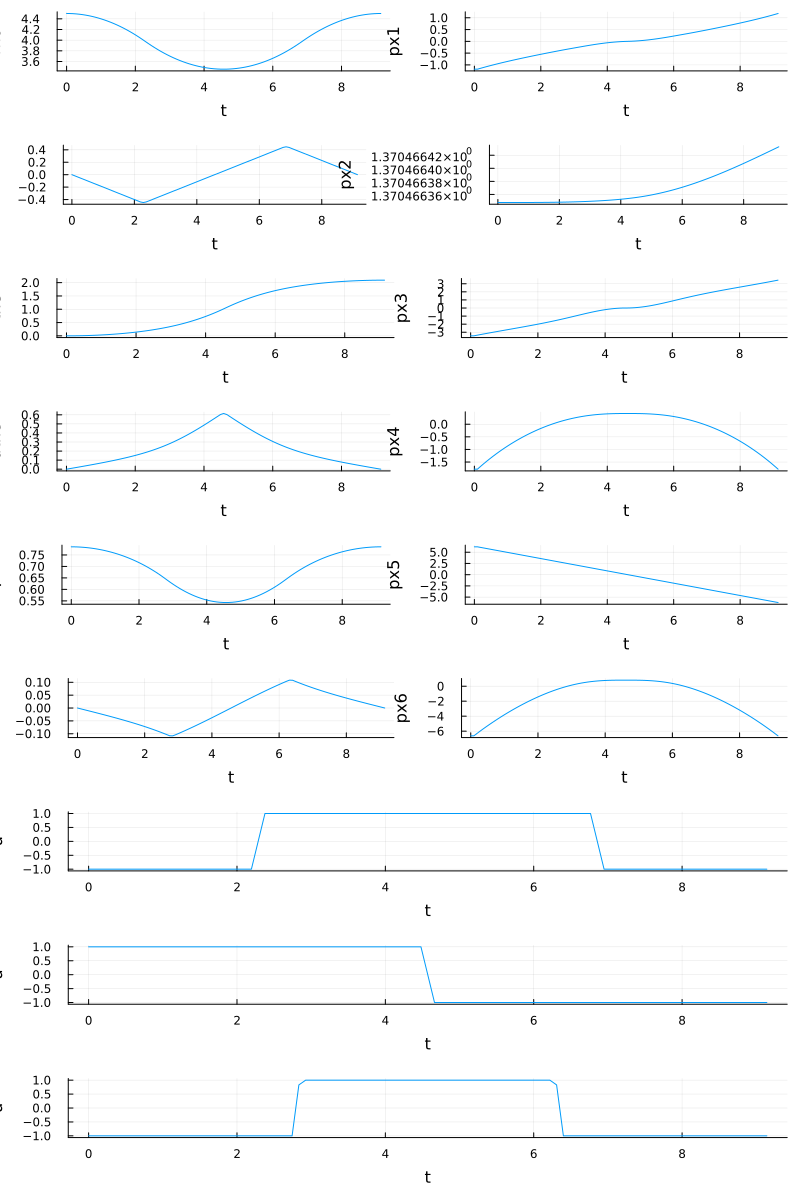

In [5]:
using Plots

x1_plot = plot(t, [ x[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "rho", legend = false)
x2_plot = plot(t, [ x[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "drho", legend = false)
x3_plot = plot(t, [ x[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "the", legend = false)
x4_plot = plot(t, [ x[i][4] for i in 1:N+1 ], xlabel = "t", ylabel = "dthe", legend = false)
x5_plot = plot(t, [ x[i][5] for i in 1:N+1 ], xlabel = "t", ylabel = "phi", legend = false)
x6_plot = plot(t, [ x[i][6] for i in 1:N+1 ], xlabel = "t", ylabel = "dphi", legend = false)
px1_plot = plot(t, [ p[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "px1", legend = false)
px2_plot = plot(t, [ p[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "px2", legend = false)
px3_plot = plot(t, [ p[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "px3", legend = false)
px4_plot = plot(t, [ p[i][4] for i in 1:N+1 ], xlabel = "t", ylabel = "px4", legend = false)
px5_plot = plot(t, [ p[i][5] for i in 1:N+1 ], xlabel = "t", ylabel = "px5", legend = false)
px6_plot = plot(t, [ p[i][6] for i in 1:N+1 ], xlabel = "t", ylabel = "px6", legend = false)

u1_plot = plot(t, [ u[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "u", legend = false)
u2_plot = plot(t, [ u[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "u", legend = false)
u3_plot = plot(t, [ u[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "u", legend = false)

layout = @layout [a b; c d; e f; g h; i j; k l; m; o; p]
x_plot = plot(x1_plot, px1_plot, x2_plot, px2_plot, x3_plot, px3_plot, 
            x4_plot, px4_plot, x5_plot, px5_plot, x6_plot, px6_plot,
            u1_plot, u2_plot, u3_plot, layout = layout)
x_plot = plot!(size = (800, 1200))

display(x_plot)

## 2. Solving with OptimalControl <a id='oc'></a>

In [6]:
using OptimalControl
include("../Problems/OptimalControl/robot_OC.jl")
RobotOC = robot_OC()


The (autonomous) optimal control problem is given by:

    L = 5.0
    max_u_rho = 1.0
    max_u_the = 1.0
    max_u_phi = 1.0
    max_u = [max_u_rho, max_u_the, max_u_phi]
    rho0 = 4.5
    phi0 = pi / 4
    thef = (2.0pi) / 3
    t0 = 0.0
    tf ∈ R, variable
    t ∈ [t0, tf], time
    x ∈ R⁶, state
    u ∈ R³, control
    rho = x₁
    rho_dot = x₂
    the = x₃
    the_dot = x₄
    phi = x₅
    phi_dot = x₆
    u1 = u₁
    u2 = u₂
    u3 = u₃
    0 ≤ rho(t) ≤ L, rho_con
    -pi ≤ the(t) ≤ pi, the_con
    0 ≤ phi(t) ≤ pi, phi_con
    -max_u_rho ≤ u₁(t) ≤ max_u_rho, u_rho_con
    -max_u_the ≤ u₂(t) ≤ max_u_the, u_the_con
    -max_u_phi ≤ u₃(t) ≤ max_u_phi, u_phi_con
    rho(t0) == rho0, rho0_con
    phi(t0) == phi0, phi0_con
    the(t0) == 0.0, the0_con
    the_dot(t0) == 0.0, the_dot0_con
    phi_dot(t0) == 0.0, phi_dot0_con
    rho_dot(t0) == 0.0, rho_dot0_con
    rho(tf) == rho0, rhof_con
    the(tf) == thef, thef_con
    phi(tf) == phi0, phif_con
    the_dot(tf) == 0.0, the_dotf_


┌────────┬────────┬──────────┬──────────┬───────────┬────────────┬─────────────┐
│ times* │ state* │ control* │ variable │ dynamics* │ objective* │ constraints │
├────────┼────────┼──────────┼──────────┼───────────┼────────────┼─────────────┤
│     ✅ │     ✅ │       ✅ │       ✅ │        ✅ │         ✅ │          ✅ │
└────────┴────────┴──────────┴──────────┴───────────┴────────────┴─────────────┘


In [7]:
# Initial guess
rho0 = 4.5
phi0 = pi/4

xinit = t -> [rho0,
        2*pi/3*(t^2),
        phi0,
        0.0,
        4*pi/3*t,
        0.0]
uinit = [0.0, 0.0, 0.0]
init = (state = xinit, control = uinit , variable= 1.0)

# Solve the problem
sol = OptimalControl.solve(RobotOC,init = init, grid_size = nh)

Method = (:direct, :adnlp, :ipopt)
This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     3612
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1414

Total number of variables............................:      910
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      606
                     variables with only upper bounds:        0
Total number of equality constraints.................:      612
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+00 2.32e+00 1.40e-03   0.

CTBase.OptimalControlSolution

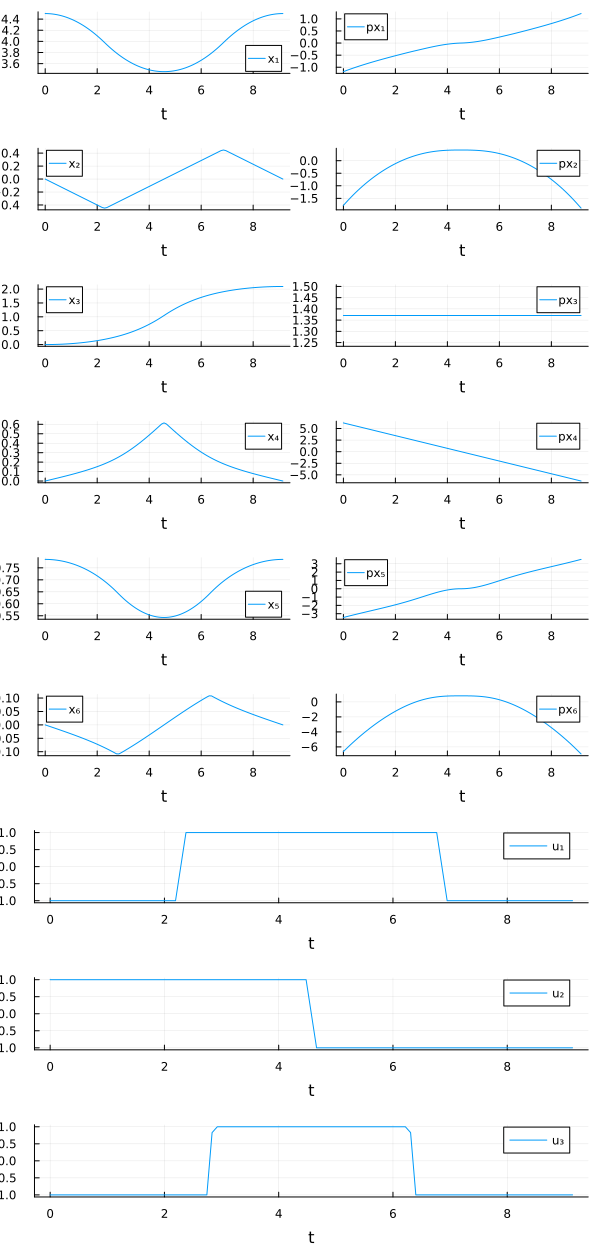

In [8]:
plot(sol)

## 3. Comparison <a id='comp'></a>

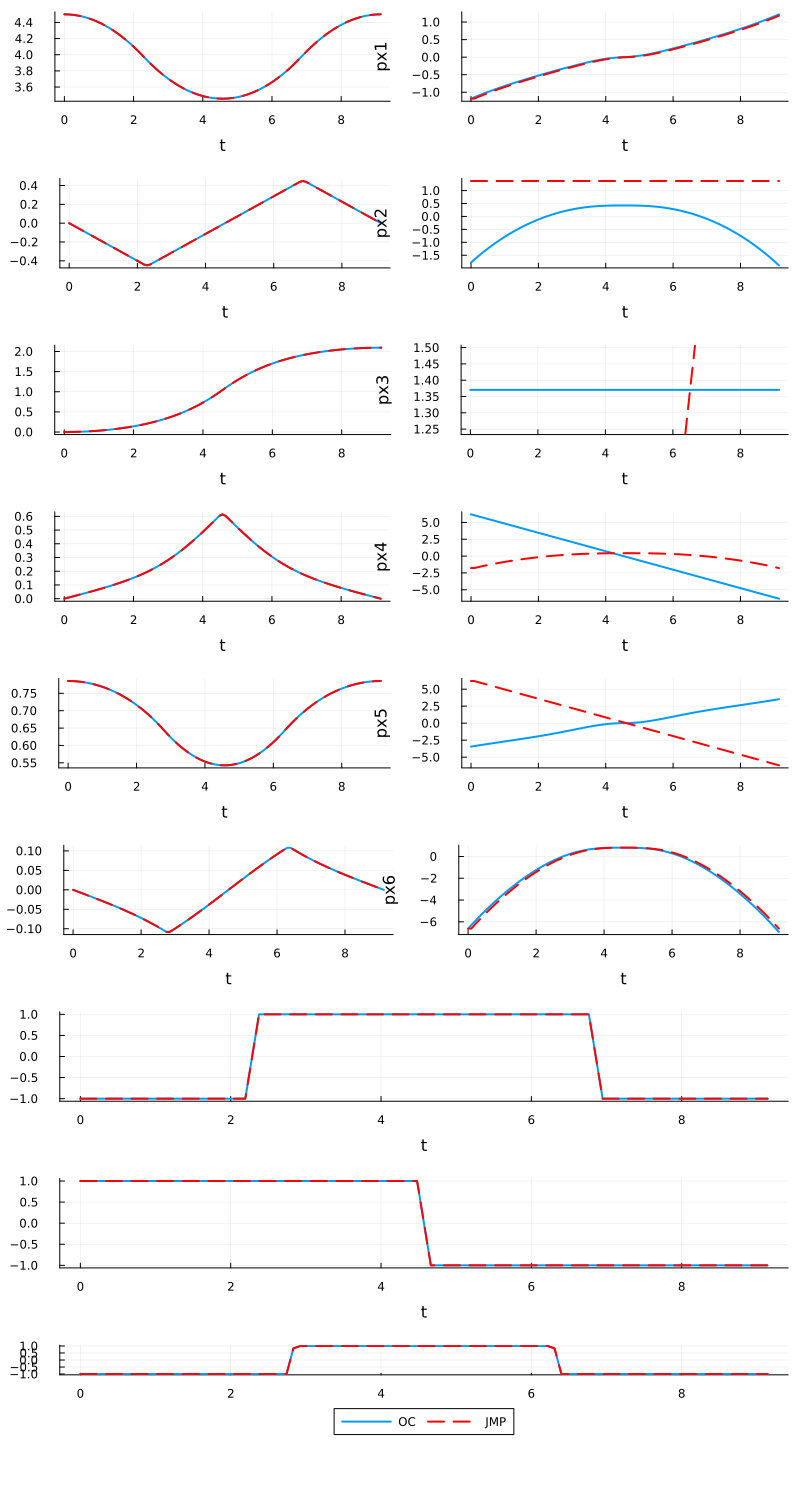

In [9]:
p1 = plot(plot(sol)[1],line = 2)
p1 = plot!(t, [ x[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "rho", legend = false,line = 2, color = "red",linestyle=:dash)

p2 = plot(plot(sol)[7],line = 2)
p2 = plot!(t, [ p[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "px1", legend = false,line = 2, color = "red",linestyle=:dash)

p3 = plot(plot(sol)[2],line = 2)
p3 = plot!(t, [ x[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "rho_dot", legend = false,line = 2, color = "red",linestyle=:dash)

p4 = plot(plot(sol)[8],line = 2)
p4 = plot!(t, [ p[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "px2", legend = false,line = 2, color = "red",linestyle=:dash)

p5 = plot(plot(sol)[3],line = 2)
p5 = plot!(t, [ x[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "the", legend = false,line = 2, color = "red",linestyle=:dash)

p6 = plot(plot(sol)[9],line = 2)
p6 = plot!(t, [ p[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "px3", legend = false,line = 2, color = "red",linestyle=:dash)

p7 = plot(plot(sol)[4],line = 2)
p7 = plot!(t, [x[i][4] for i in 1:N+1], xlabel = "t", ylabel = "the_dot", legend = false,line = 2, color = "red",linestyle=:dash)

p8 = plot(plot(sol)[10],line = 2)
p8 = plot!(t, [p[i][4] for i in 1:N+1], xlabel = "t", ylabel = "px4", legend = false,line = 2, color = "red",linestyle=:dash)

p9 = plot(plot(sol)[5],line = 2)
p9 = plot!(t, [x[i][5] for i in 1:N+1], xlabel = "t", ylabel = "phi", legend = false,line = 2, color = "red",linestyle=:dash)

p10 = plot(plot(sol)[11],line = 2)
p10 = plot!(t, [p[i][5] for i in 1:N+1], xlabel = "t", ylabel = "px5", legend = false,line = 2, color = "red",linestyle=:dash)

p11 = plot(plot(sol)[6],line = 2)
p11 = plot!(t, [x[i][6] for i in 1:N+1], xlabel = "t", ylabel = "phi_dot", legend = false,line = 2, color = "red",linestyle=:dash)

p12 = plot(plot(sol)[12],line = 2)
p12 = plot!(t, [p[i][6] for i in 1:N+1], xlabel = "t", ylabel = "px6", legend = false,line = 2, color = "red",linestyle=:dash)

p13 = plot(plot(sol)[13],line = 2)
p13 = plot!(t, [ u[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "u1", legend = false,line = 2, color = "red",linestyle=:dash)

p14 = plot(plot(sol)[14],line = 2)
p14 = plot!(t, [ u[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "u2", legend = false,line = 2, color = "red",linestyle=:dash)

p15 = plot(plot(sol)[15],label ="OC",line = 2)
p15 = plot!(t, [ u[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "u3", legend = false , label = "JMP",line = 2, color = "red",linestyle=:dash)
p15 = plot!(legend=:outerbottom, legendcolumns=2)

layout = @layout [a b; c d; e f; g h; i j; k l; m; o; p]

x_plot = plot(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, p15, layout = layout)
x_plot = plot!(size = (800, 1500))

display(x_plot)